## Here is walk-through to help getting started with tensorflow

1) Simple Linear Regression with low-level TensorFlow  
2) Simple Linear Regression with a canned estimator  
3) Playing with real data: linear regressor and DNN  
4) Building a custom estimator to classify handwritten digits (MNIST)

### [What's next?](https://goo.gl/hZaLPA)

## Dependencies

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections

# tensorflow
import tensorflow as tf
print('Expected TensorFlow version is v1.3.0 or higher')
print('Your TensorFlow version:', tf.__version__)

# data manipulation
import numpy as np
import pandas as pd

# visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12,8]

ImportError: No module named tensorflow

## 1) Simple Linear Regression with low-level TensorFlow

### Generating data

This function creates a noisy dataset that's roughly linear, according to the equation y = mx + b + noise.

Notice that the expected value for m is 0.1 and for b is 0.3. This is the values we expect the model to predict.

In [2]:
def make_noisy_data(m=0.1, b=0.3, n=100):
    x = np.random.randn(n)
    noise = np.random.normal(scale=0.01, size=len(x))
    y = m * x + b + noise
    return x, y

Create training data

In [3]:
x_train, y_train = make_noisy_data()

Plot the training data

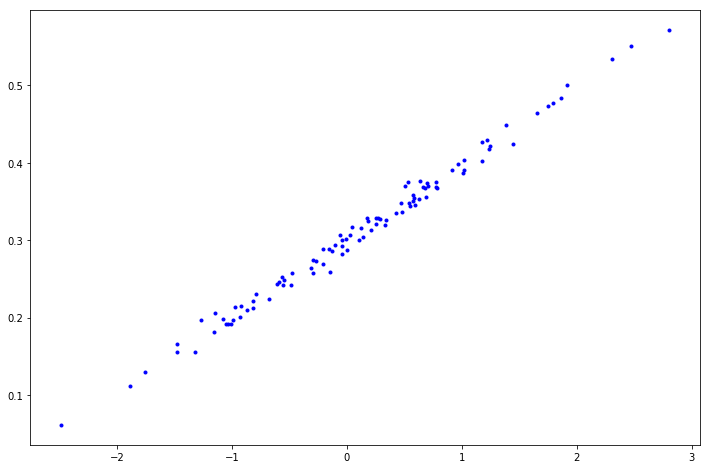

In [4]:
plt.plot(x_train, y_train, 'b.')

### The Model

In [5]:
# input and output
x = tf.placeholder(shape=[None], dtype=tf.float32, name='x')
y_label = tf.placeholder(shape=[None], dtype=tf.float32, name='y_label')

# variables
W = tf.Variable(tf.random_normal([1], name="W")) # weight
b = tf.Variable(tf.random_normal([1], name="b")) # bias

# actual model
y = W * x + b

### The Loss and Optimizer

Define a loss function (here, squared error) and an optimizer (here, gradient descent).

In [6]:
loss = tf.reduce_mean(tf.square(y - y_label))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
train = optimizer.minimize(loss)

### The Training Loop and generating predictions

In [7]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init) # initialize variables
  for i in range(100): # train for 100 steps
    sess.run(train, feed_dict={x: x_train, y_label:y_train})

  x_plot = np.linspace(-3, 3, 101) # return evenly spaced numbers over a specified interval
  # using the trained model to predict values for the training data
  y_plot = sess.run(y, feed_dict={x: x_plot})

  # saving final weight and bias
  final_W = sess.run(W)
  final_b = sess.run(b)

### Visualizing predictions

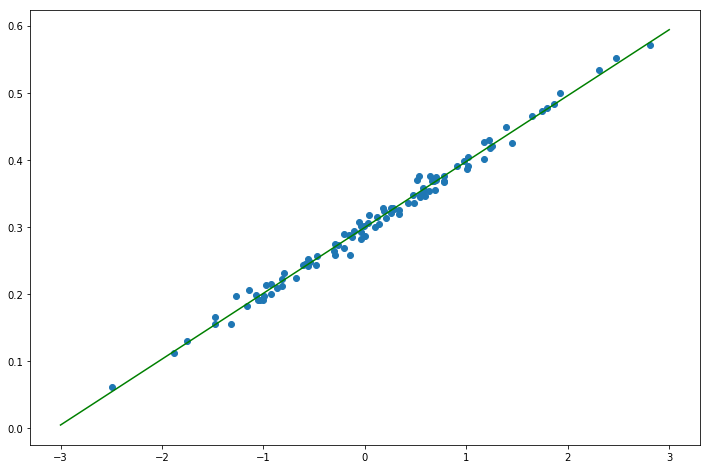

In [8]:
plt.scatter(x_train, y_train)
plt.plot(x_plot, y_plot, 'g')

### What is the final weight and bias?

In [9]:
print('W:', final_W, 'expected: 0.1')
print('b:', final_b, 'expected: 0.3')

W: [ 0.0981679] expected: 0.1
b: [ 0.29952455] expected: 0.3


## 2) Simple Linear Regression with a canned estimator  

### Input Pipeline

In [10]:
x_dict = {'x': x_train}
train_input = tf.estimator.inputs.numpy_input_fn(x_dict, y_train,
                                                 shuffle=True,
                                                 num_epochs=None) # repeat forever

### Describe input feature usage

In [11]:
features = [tf.feature_column.numeric_column('x')] # because x is a real number

### Build and train the model

In [12]:
estimator = tf.estimator.LinearRegressor(features)
estimator.train(train_input, steps = 1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': '/tmp/tmp_eQRnF', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp_eQRnF/model.ckpt.
INFO:tensorflow:loss = 13.0993, step = 1
INFO:tensorflow:global_step/sec: 863.991
INFO:tensorflow:loss = 0.0107502, step = 101 (0.117 sec)
INFO:tensorflow:global_step/sec: 1104.09
INFO:tensorflow:loss = 0.0100529, step = 201 (0.091 sec)
INFO:tensorflow:global_step/sec: 1063.31
INFO:tensorflow:loss = 0.00941867, step = 301 (0.094 sec)
INFO:tensorflow:global_step/sec: 1115.05
INFO:tensorflow:loss = 0.0109864, step = 401 (0.090 sec)
INFO:tensorflow:global_step/sec: 1212.36
INFO:tensorflow:loss = 0.0092965, step = 501 (0.082 sec)
INFO:tensorfl

### Generating and visualizing predictions

In [13]:
x_test_dict = {'x': np.linspace(-5, 5, 11)}
data_source = tf.estimator.inputs.numpy_input_fn(x_test_dict, shuffle=False)

predictions = list(estimator.predict(data_source))
preds = [p['predictions'][0] for p in predictions]

for y in predictions:
    print(y['predictions'])

INFO:tensorflow:Restoring parameters from /tmp/tmp_eQRnF/model.ckpt-1000
[-0.19218418]
[-0.0937537]
[ 0.00467679]
[ 0.10310729]
[ 0.20153779]
[ 0.29996827]
[ 0.39839876]
[ 0.49682927]
[ 0.59525979]
[ 0.69369024]
[ 0.7921207]


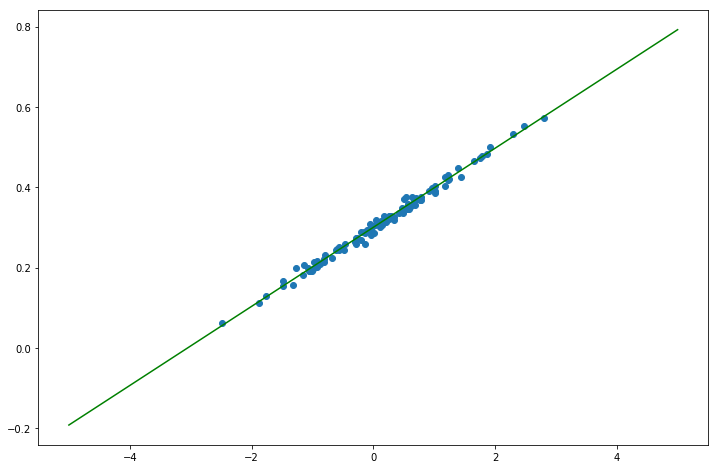

In [14]:
plt.scatter(x_train, y_train)
plt.plot(x_test_dict['x'], preds, 'g')

## 3) Playing with real data: linear regressor and DNN  

### Get the data

The Adult dataset is from the Census bureau and the task is to predict whether a given adult makes more than $50,000 a year based attributes such as education, hours of work per week, etc.

But the code here presented can be easilly aplicable to any csv dataset that fits in memory.

More about the data [here](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/old.adult.names)

In [15]:
census_train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
census_train_path = tf.contrib.keras.utils.get_file('census.train', census_train_url)

census_test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
census_test_path = tf.contrib.keras.utils.get_file('census.test', census_test_url)

### Load the data

In [16]:
column_names = [
  'age', 'workclass', 'fnlwgt', 'education', 'education-num',
  'marital-status', 'occupation', 'relationship', 'race', 'sex',
  'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
  'income'
]

census_train = pd.read_csv(census_train_path, index_col=False, names=column_names) 
census_test = pd.read_csv(census_train_path, index_col=False, names=column_names) 

census_train_label = census_train.pop('income') == " >50K" 
census_test_label = census_test.pop('income') == " >50K"

In [17]:
census_train.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States


In [18]:
census_train_label[:20]

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7      True
8      True
9      True
10     True
11     True
12    False
13    False
14     True
15    False
16    False
17    False
18    False
19     True
Name: income, dtype: bool

### Input pipeline

In [19]:
train_input = tf.estimator.inputs.pandas_input_fn(
    census_train, 
    census_train_label,
    shuffle=True, 
    batch_size = 32, # process 32 examples at a time
    num_epochs=None,
)

In [20]:
test_input = tf.estimator.inputs.pandas_input_fn(
    census_test, 
    census_test_label, 
    shuffle=True, 
    num_epochs=1)

In [21]:
features, labels = train_input()
features

{'age': <tf.Tensor 'random_shuffle_queue_DequeueMany:1' shape=(32,) dtype=int64>,
 'capital-gain': <tf.Tensor 'random_shuffle_queue_DequeueMany:11' shape=(32,) dtype=int64>,
 'capital-loss': <tf.Tensor 'random_shuffle_queue_DequeueMany:12' shape=(32,) dtype=int64>,
 'education': <tf.Tensor 'random_shuffle_queue_DequeueMany:4' shape=(32,) dtype=string>,
 'education-num': <tf.Tensor 'random_shuffle_queue_DequeueMany:5' shape=(32,) dtype=int64>,
 'fnlwgt': <tf.Tensor 'random_shuffle_queue_DequeueMany:3' shape=(32,) dtype=int64>,
 'hours-per-week': <tf.Tensor 'random_shuffle_queue_DequeueMany:13' shape=(32,) dtype=int64>,
 'marital-status': <tf.Tensor 'random_shuffle_queue_DequeueMany:6' shape=(32,) dtype=string>,
 'native-country': <tf.Tensor 'random_shuffle_queue_DequeueMany:14' shape=(32,) dtype=string>,
 'occupation': <tf.Tensor 'random_shuffle_queue_DequeueMany:7' shape=(32,) dtype=string>,
 'race': <tf.Tensor 'random_shuffle_queue_DequeueMany:9' shape=(32,) dtype=string>,
 'relations

### Feature description

In [22]:
features = [
    tf.feature_column.numeric_column('hours-per-week'),
    tf.feature_column.bucketized_column(tf.feature_column.numeric_column('education-num'), list(range(25))),
    tf.feature_column.categorical_column_with_vocabulary_list('sex', ['male','female']),
    tf.feature_column.categorical_column_with_hash_bucket('native-country', 1000),
]

In [23]:
estimator = tf.estimator.LinearClassifier(features, model_dir='census/linear',n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': 'census/linear', '_save_summary_steps': 100}


In [24]:
estimator.train(train_input, steps=5000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from census/linear/model.ckpt-7000
INFO:tensorflow:Saving checkpoints for 7001 into census/linear/model.ckpt.
INFO:tensorflow:loss = 20.1149, step = 7001
INFO:tensorflow:global_step/sec: 302.798
INFO:tensorflow:loss = 15.1638, step = 7101 (0.336 sec)
INFO:tensorflow:global_step/sec: 467.31
INFO:tensorflow:loss = 12.2227, step = 7201 (0.213 sec)
INFO:tensorflow:global_step/sec: 440.354
INFO:tensorflow:loss = 12.9704, step = 7301 (0.226 sec)
INFO:tensorflow:global_step/sec: 453.844
INFO:tensorflow:loss = 14.7049, step = 7401 (0.221 sec)
INFO:tensorflow:global_step/sec: 375.504
INFO:tensorflow:loss = 14.1362, step = 7501 (0.266 sec)
INFO:tensorflow:global_step/sec: 455.45
INFO:tensorflow:loss = 16.6804, step = 7601 (0.218 sec)
INFO:tensorflow:global_step/sec: 458.844
INFO:tensorflow:loss = 17.2591, step = 7701 (0.219 sec)
INFO:tensorflow:global_step/sec: 458.789
INFO:tensorflow:loss = 10.5894, step = 7801 (0.

### Evaluate the model

In [25]:
estimator.evaluate(test_input)

INFO:tensorflow:Starting evaluation at 2017-07-13-18:04:05
INFO:tensorflow:Restoring parameters from census/linear/model.ckpt-12000
INFO:tensorflow:Finished evaluation at 2017-07-13-18:04:06
INFO:tensorflow:Saving dict for global step 12000: accuracy = 0.784036, accuracy_baseline = 0.75919, auc = 0.764093, auc_precision_recall = 0.511886, average_loss = 0.468169, global_step = 12000, label/mean = 0.24081, loss = 59.7806, prediction/mean = 0.228052


{'accuracy': 0.7840361,
 'accuracy_baseline': 0.75919044,
 'auc': 0.7640928,
 'auc_precision_recall': 0.51188624,
 'average_loss': 0.46816874,
 'global_step': 12000,
 'label/mean': 0.24080956,
 'loss': 59.780556,
 'prediction/mean': 0.22805227}

## DNN model

### Update input pre-processing

In [26]:
features = [
    tf.feature_column.numeric_column('education-num'),
    tf.feature_column.numeric_column('hours-per-week'),
    tf.feature_column.numeric_column('age'),
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list('sex',['male','female'])),
    tf.feature_column.embedding_column(  # now using embedding!
        tf.feature_column.categorical_column_with_hash_bucket('native-country', 1000), 10)
]

In [27]:
estimator = tf.estimator.DNNClassifier(hidden_units=[20,20], 
                                       feature_columns=features, 
                                       n_classes=2, 
                                       model_dir='census/dnn')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': 'census/dnn', '_save_summary_steps': 100}


In [28]:
estimator.train(train_input, steps=5000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from census/dnn/model.ckpt-6001
INFO:tensorflow:Saving checkpoints for 6002 into census/dnn/model.ckpt.
INFO:tensorflow:loss = 15.0321, step = 6002
INFO:tensorflow:global_step/sec: 286.769
INFO:tensorflow:loss = 13.2672, step = 6102 (0.358 sec)
INFO:tensorflow:global_step/sec: 354.447
INFO:tensorflow:loss = 7.71313, step = 6202 (0.276 sec)
INFO:tensorflow:global_step/sec: 358.693
INFO:tensorflow:loss = 15.6592, step = 6302 (0.281 sec)
INFO:tensorflow:global_step/sec: 452.398
INFO:tensorflow:loss = 13.5664, step = 6402 (0.221 sec)
INFO:tensorflow:global_step/sec: 408.684
INFO:tensorflow:loss = 13.1125, step = 6502 (0.246 sec)
INFO:tensorflow:global_step/sec: 399.251
INFO:tensorflow:loss = 11.5031, step = 6602 (0.249 sec)
INFO:tensorflow:global_step/sec: 382.475
INFO:tensorflow:loss = 14.8688, step = 6702 (0.262 sec)
INFO:tensorflow:global_step/sec: 454.932
INFO:tensorflow:loss = 9.32517, step = 6802 (0.222 

In [29]:
estimator.evaluate(test_input)

INFO:tensorflow:Starting evaluation at 2017-07-13-18:04:21
INFO:tensorflow:Restoring parameters from census/dnn/model.ckpt-11001
INFO:tensorflow:Finished evaluation at 2017-07-13-18:04:22
INFO:tensorflow:Saving dict for global step 11001: accuracy = 0.799177, accuracy_baseline = 0.75919, auc = 0.821079, auc_precision_recall = 0.585971, average_loss = 0.421931, global_step = 11001, label/mean = 0.24081, loss = 53.8765, prediction/mean = 0.220763


{'accuracy': 0.79917693,
 'accuracy_baseline': 0.75919044,
 'auc': 0.82107949,
 'auc_precision_recall': 0.585971,
 'average_loss': 0.42193109,
 'global_step': 11001,
 'label/mean': 0.24080956,
 'loss': 53.876461,
 'prediction/mean': 0.22076258}

## Custom Input Pipeline using Datasets API

### Read the data

In [30]:
def census_input_fn(path):
    def input_fn():    
        dataset = (
            tf.contrib.data.TextLineDataset(path)
                .map(csv_decoder)
                .shuffle(buffer_size=100)
                .batch(32)
                .repeat())

        columns = dataset.make_one_shot_iterator().get_next()

        income = tf.equal(columns.pop('income')," >50K") 

        return columns, income
    
    return input_fn

In [31]:
csv_defaults = collections.OrderedDict([
  ('age',[0]),
  ('workclass',['']),
  ('fnlwgt',[0]),
  ('education',['']),
  ('education-num',[0]),
  ('marital-status',['']),
  ('occupation',['']),
  ('relationship',['']),
  ('race',['']),
  ('sex',['']),
  ('capital-gain',[0]),
  ('capital-loss',[0]),
  ('hours-per-week',[0]),
  ('native-country',['']),
  ('income',['']),
])

In [32]:
def csv_decoder(line):
  parsed = tf.decode_csv(line, csv_defaults.values())
  return dict(zip(csv_defaults.keys(), parsed))
  

### Try the input function

In [33]:
tf.reset_default_graph()
census_input = census_input_fn(census_train_path)
training_batch = census_input()

In [34]:
with tf.Session() as sess:
    features, high_income = sess.run(training_batch)

In [35]:
print(features['education'])

[' HS-grad' ' Bachelors' ' HS-grad' ' HS-grad' ' HS-grad' ' Assoc-voc'
 ' 11th' ' HS-grad' ' HS-grad' ' HS-grad' ' HS-grad' ' 5th-6th'
 ' Some-college' ' HS-grad' ' Some-college' ' HS-grad' ' HS-grad'
 ' HS-grad' ' Assoc-voc' ' Bachelors' ' 9th' ' 7th-8th' ' HS-grad'
 ' Bachelors' ' Assoc-acdm' ' Some-college' ' 7th-8th' ' HS-grad'
 ' Assoc-voc' ' HS-grad' ' Bachelors' ' HS-grad']


In [36]:
print(features['age'])

[54 50 47 49 52 57 38 19 44 48 32 46 49 53 43 29 19 30 49 44 31 32 30 31 48
 55 34 49 29 27 40 42]


In [37]:
print(high_income)

[False False False False  True False False False  True False  True False
  True  True  True False False False  True  True False False False False
 False False False False False False False False]


## 4) Building a custom estimator to classify handwritten digits (MNIST)

![mnist](http://rodrigob.github.io/are_we_there_yet/build/images/mnist.png?1363085077)
Image from: http://rodrigob.github.io/are_we_there_yet/build/images/mnist.png?1363085077

In [38]:
train,test = tf.contrib.keras.datasets.mnist.load_data()
x_train,y_train = train 
x_test,y_test = test

mnist_train_input = tf.estimator.inputs.numpy_input_fn({'x':np.array(x_train, dtype=np.float32)},
                                                       np.array(y_train,dtype=np.int32),
                                                       shuffle=True,
                                                       num_epochs=None)

mnist_test_input = tf.estimator.inputs.numpy_input_fn({'x':np.array(x_test, dtype=np.float32)},
                                                      np.array(y_test,dtype=np.int32),
                                                      shuffle=True,
                                                      num_epochs=1)


### tf.estimator.LinearClassifier

In [40]:
estimator = tf.estimator.LinearClassifier([tf.feature_column.numeric_column('x',shape=784)], 
                                          n_classes=10,
                                          model_dir="mnist/linear")
estimator.train(mnist_train_input, steps = 10000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': 'mnist/linear', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from mnist/linear/model.ckpt-40002
INFO:tensorflow:Saving checkpoints for 40003 into mnist/linear/model.ckpt.
INFO:tensorflow:loss = 523.441, step = 40003
INFO:tensorflow:global_step/sec: 522.507
INFO:tensorflow:loss = 224.057, step = 40103 (0.192 sec)
INFO:tensorflow:global_step/sec: 765.69
INFO:tensorflow:loss = 328.933, step = 40203 (0.131 sec)
INFO:tensorflow:global_step/sec: 814.354
INFO:tensorflow:loss = 192.314, step = 40303 (0.123 sec)
INFO:tensorflow:global_step/sec: 919.682
INFO:tensorflow:loss = 472.075, step = 40403 (0.109 sec)
INFO:tensorflow:global_step/sec: 915.

INFO:tensorflow:global_step/sec: 907.408
INFO:tensorflow:loss = 556.473, step = 47903 (0.110 sec)
INFO:tensorflow:global_step/sec: 976.037
INFO:tensorflow:loss = 434.922, step = 48003 (0.102 sec)
INFO:tensorflow:global_step/sec: 897.385
INFO:tensorflow:loss = 610.174, step = 48103 (0.111 sec)
INFO:tensorflow:global_step/sec: 813.736
INFO:tensorflow:loss = 603.513, step = 48203 (0.123 sec)
INFO:tensorflow:global_step/sec: 833.535
INFO:tensorflow:loss = 167.918, step = 48303 (0.120 sec)
INFO:tensorflow:global_step/sec: 851.587
INFO:tensorflow:loss = 546.752, step = 48403 (0.117 sec)
INFO:tensorflow:global_step/sec: 951.383
INFO:tensorflow:loss = 358.82, step = 48503 (0.105 sec)
INFO:tensorflow:global_step/sec: 919.584
INFO:tensorflow:loss = 744.178, step = 48603 (0.109 sec)
INFO:tensorflow:global_step/sec: 905.698
INFO:tensorflow:loss = 77.2728, step = 48703 (0.110 sec)
INFO:tensorflow:global_step/sec: 948.991
INFO:tensorflow:loss = 206.162, step = 48803 (0.105 sec)
INFO:tensorflow:globa

In [41]:
estimator.evaluate(mnist_test_input)

INFO:tensorflow:Starting evaluation at 2017-07-13-18:04:35
INFO:tensorflow:Restoring parameters from mnist/linear/model.ckpt-50002
INFO:tensorflow:Finished evaluation at 2017-07-13-18:04:35
INFO:tensorflow:Saving dict for global step 50002: accuracy = 0.9012, average_loss = 4.98164, global_step = 50002, loss = 630.588


{'accuracy': 0.9012,
 'average_loss': 4.9816413,
 'global_step': 50002,
 'loss': 630.58752}

### Examine the results with [TensorBoard](http://0.0.0.0:6006)
$> tensorboard --logdir census

In [42]:
estimator = tf.estimator.DNNClassifier(hidden_units=[256],
                                       feature_columns=[tf.feature_column.numeric_column('x',shape=784)], 
                                       n_classes=10,
                                       model_dir="mnist/DNN")
estimator.train(mnist_train_input, steps = 10000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': 'mnist/DNN', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from mnist/DNN/model.ckpt-40001
INFO:tensorflow:Saving checkpoints for 40002 into mnist/DNN/model.ckpt.
INFO:tensorflow:loss = 20.4059, step = 40002
INFO:tensorflow:global_step/sec: 333.091
INFO:tensorflow:loss = 25.0221, step = 40102 (0.300 sec)
INFO:tensorflow:global_step/sec: 367.488
INFO:tensorflow:loss = 34.8886, step = 40202 (0.272 sec)
INFO:tensorflow:global_step/sec: 370.04
INFO:tensorflow:loss = 27.3445, step = 40302 (0.270 sec)
INFO:tensorflow:global_step/sec: 374.413
INFO:tensorflow:loss = 19.9712, step = 40402 (0.267 sec)
INFO:tensorflow:global_step/sec: 375.55
INFO:t

INFO:tensorflow:loss = 14.2463, step = 47902 (0.284 sec)
INFO:tensorflow:global_step/sec: 378.838
INFO:tensorflow:loss = 31.2345, step = 48002 (0.264 sec)
INFO:tensorflow:global_step/sec: 344.783
INFO:tensorflow:loss = 15.5333, step = 48102 (0.290 sec)
INFO:tensorflow:global_step/sec: 391.137
INFO:tensorflow:loss = 31.9774, step = 48202 (0.256 sec)
INFO:tensorflow:global_step/sec: 394.328
INFO:tensorflow:loss = 12.7595, step = 48302 (0.254 sec)
INFO:tensorflow:global_step/sec: 349.371
INFO:tensorflow:loss = 18.8486, step = 48402 (0.286 sec)
INFO:tensorflow:global_step/sec: 384.397
INFO:tensorflow:loss = 8.32962, step = 48502 (0.260 sec)
INFO:tensorflow:global_step/sec: 348.682
INFO:tensorflow:loss = 23.0522, step = 48602 (0.287 sec)
INFO:tensorflow:global_step/sec: 373.4
INFO:tensorflow:loss = 33.2136, step = 48702 (0.268 sec)
INFO:tensorflow:global_step/sec: 329.296
INFO:tensorflow:loss = 8.8079, step = 48802 (0.304 sec)
INFO:tensorflow:global_step/sec: 390.692
INFO:tensorflow:loss = 

In [43]:
estimator.evaluate(mnist_test_input)

INFO:tensorflow:Starting evaluation at 2017-07-13-18:05:03
INFO:tensorflow:Restoring parameters from mnist/DNN/model.ckpt-50001
INFO:tensorflow:Finished evaluation at 2017-07-13-18:05:03
INFO:tensorflow:Saving dict for global step 50001: accuracy = 0.9402, average_loss = 0.289987, global_step = 50001, loss = 36.7072


{'accuracy': 0.94019997,
 'average_loss': 0.2899867,
 'global_step': 50001,
 'loss': 36.707176}

In [44]:
# Parameters
BATCH_SIZE = 128
STEPS = 10000

## A Custom Model

In [53]:
def build_cnn(input_layer, mode):
  with tf.name_scope("CNN"):
      conv1 = tf.layers.conv2d(inputs=input_layer,filters=32, kernel_size=[5, 5],
                               padding='same', activation=tf.nn.relu)
      pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

      conv2 = tf.layers.conv2d(inputs=pool1,filters=64, kernel_size=[5, 5],
                               padding='same', activation=tf.nn.relu)
      pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

      pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

      dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

      is_training_mode = mode == tf.estimator.ModeKeys.TRAIN
      dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=is_training_mode)

      logits = tf.layers.dense(inputs=dropout, units=10)
        
      return logits


In [62]:
def model_fn(features, labels, mode):
  # Describing the model
  input_layer = tf.reshape(features['x'], [-1, 28, 28, 1])
    
  tf.summary.image('mnist_input',input_layer)
    
  logits = build_cnn(input_layer, mode)
 
  # Generate Predictions
  classes = tf.argmax(input=logits, axis=1)
  predictions = {
      'classes': classes,
      'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    # Return an EstimatorSpec object
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
  loss = tf.reduce_sum(loss)

  tf.summary.scalar('loss', loss)
    
  accuracy = tf.cast(tf.equal(tf.cast(classes,tf.int32),labels),tf.float32)
  accuracy = tf.reduce_mean(accuracy)
  tf.summary.scalar('accuracy', accuracy)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.train.get_global_step(),
        learning_rate=1e-4,
        optimizer='Adam')

    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                      loss=loss, train_op=train_op)

  # Configure the accuracy metric for evaluation
  eval_metric_ops = {
      'accuracy': tf.metrics.accuracy(
          classes,
          input=labels)
  }

  return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                    loss=loss, eval_metric_ops=eval_metric_ops)


## Runs estimator

In [63]:
# create estimator
run_config = tf.contrib.learn.RunConfig(model_dir='mnist/CNN')
estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config)

# train for 10000 steps
estimator.train(input_fn=mnist_train_input, steps=10000)

# evaluate
estimator.evaluate(input_fn=mnist_test_input)

# predict
preds = estimator.predict(input_fn=test_input_fn)

INFO:tensorflow:Using config: {'_model_dir': 'mnist/CNN', '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_session_config': None, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5679e16d90>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_log_step_count_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from mnist/CNN/model.ckpt-2
INFO:tensorflow:Saving checkpoints for 3 into mnist/CNN/model.ckpt.
INFO:tensorflow:loss = 2716.56, step = 3


KeyboardInterrupt: 

## Distributed tensorflow: using experiments

In [ ]:
# Run an experiment
from tensorflow.contrib.learn.python.learn import learn_runner

# Enable TensorFlow logs
tf.logging.set_verbosity(tf.logging.INFO)

In [ ]:
# create experiment
def experiment_fn(run_config, hparams):
  # create estimator
  estimator = tf.estimator.Estimator(model_fn=model_fn,
                                     config=run_config)
  return tf.contrib.learn.Experiment(
      estimator,
      train_input_fn=train_input_fn,
      eval_input_fn=test_input_fn,
      train_steps=STEPS
  )

# run experiment
learn_runner.run(experiment_fn,
    run_config=run_config)

### Examine the results with [TensorBoard](http://0.0.0.0:6006)
$> tensorboard --logdir census